<a href="https://colab.research.google.com/github/elliotgengler/Option-DeAmericanization/blob/main/FirstPricer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import math
import matplotlib.pyplot as plt
import time

In [ ]:
def digits_right(guess,actual):
  return -math.log10(abs(guess-actual))

def print_eval(est,actual,start,stop,prec):
  print("Estimate:",round(est,prec))
  print("Error:",round(actual-est,prec))
  print("Digits Correct:",round(digits_right(est,actual),2))
  print("Time Elapsed (s):", round(stop-start,2))

# European Option Pricing

In [ ]:
def payoff(S_0,N,j,u,d,K,is_call):
  S_t = S_0 * u**j * d**(N-j) # up j times, down N-j times
  if is_call:
    return np.maximum(S_t-K,0)
  else:
    return np.maximum(K-S_t,0)

def p_riskneutral(r,q,delta_time,u,d):
  return (math.exp((r-q)*delta_time)-d)/(u-d)

def euro_direct(S_0,K,Maturity,sigma,N,r,q,is_call):
  # compute expected payoff directly w/ the binomial pmf
  u = math.exp(sigma*math.sqrt(Maturity/N)) # CRR Assumptions
  d = math.exp(-sigma*math.sqrt(Maturity/N))

  sum = 0
  pstar = p_riskneutral(r,q,Maturity/N,u,d) # risk neutral probability of up
  for j in range(N+1):
    # add up probabilities times payoffs
    sum += math.comb(N,j) * pstar**j * (1-pstar)**(N-j) * payoff(S_0,N,j,u,d,K,is_call)

  return sum * math.exp(-r*Maturity)

In [ ]:
start = time.time()
est = euro_direct(100,100,1,0.2,1000,0.05,0.02,True)
stop = time.time()
print_eval(est,9.22701,start,stop,6)

Estimate: 9.225062
Error: 0.001948
Digits Correct: 2.71
Time Elapsed (s): 0.08


# Backwards Induction

In [ ]:
def backward_induce_euro(V,pstar,disc):
  # one step of backward induction on state vector V
  V = pstar*V[1:] + (1-pstar)*V[:-1]
  return V*disc

def euro_backward_induction(S_0,K,Maturity,sigma,N,r,q,is_call):
  # compute price using backward induction along the tree
  u = math.exp(sigma*math.sqrt(Maturity/N)) # CRR Assumptions
  d = math.exp(-sigma*math.sqrt(Maturity/N))

  pstar = p_riskneutral(r,q,Maturity/N,u,d)
  disc = math.exp(-r*Maturity/N)

  i = np.arange(N+1)
  V = payoff(S_0,N,i,u,d,K,is_call) # initialize payoffs at maturity

  for i in range(N):
    V = backward_induce_euro(V,pstar,disc)
  return V[0]

In [ ]:
start = time.time()
est = euro_backward_induction(100,100,1,0.2,5000,0.05,0.02,True)
stop = time.time()

print_eval(est,9.22701,start,stop,6)

Estimate: 9.226617
Error: 0.000393
Digits Correct: 3.41
Time Elapsed (s): 0.14


## Performance


In [ ]:
errors_dir = []
times_dir = []
for i in range(1,1001):
  start = time.time()
  errors_dir.append(euro_direct(100,100,1,0.2,i,0.05,0.02,True)-9.22701)
  stop = time.time()
  times_dir.append(stop-start)

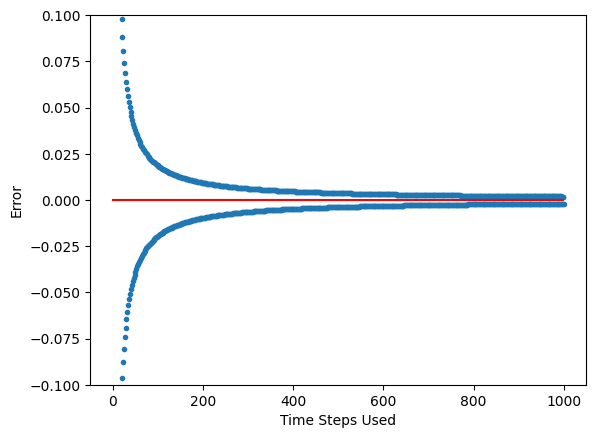

In [ ]:
plt.scatter(range(1,1001),errors_dir,marker='.')
plt.plot(np.zeros(1000),color='red')
plt.xlabel("Time Steps Used")
plt.ylabel("Error");
plt.ylim([-0.1,0.1]);

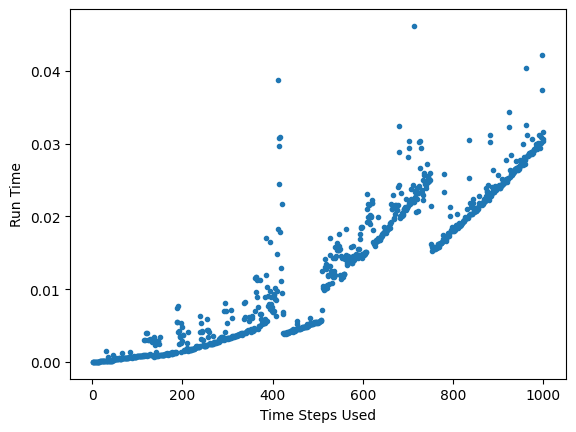

In [ ]:
plt.scatter(range(1,1001),times_dir,marker='.')
plt.xlabel("Time Steps Used")
plt.ylabel("Run Time");

In [ ]:
errors_bi = []
times_bi = []
for i in range(1,1001):
  start = time.time()
  errors_bi.append(euro_backward_induction(100,100,1,0.2,i,0.05,0.02,True)-9.22701)
  stop = time.time()
  times_bi.append(stop-start)

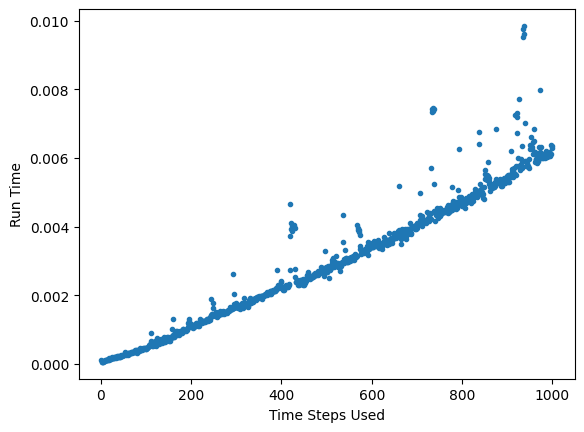

In [ ]:
plt.scatter(range(1,1001),times_bi,marker='.')
plt.xlabel("Time Steps Used")
plt.ylabel("Run Time");

# American Options

In [ ]:
def backward_induce_american(V,S,u,pstar,disc,K,is_call):
  # perform one step of backward induction on state vectors V and S
  continuing_val = pstar*V[1:] + (1-pstar)*V[:-1] # same as with european
  S = S[:-1]*u # multiplying by u (or dividing by d) walks the stocks back a step
  if is_call:
    exercise_val = np.maximum(S-K,np.zeros(S.shape[0]))
  else:
    exercise_val = np.maximum(K-S,np.zeros(S.shape[0]))
  V = np.maximum(continuing_val,exercise_val) * disc
  return V, S

In [ ]:
def american_backward_induction(S_0,K,Maturity,sigma,N,r,q,is_call):
  u = math.exp(sigma*math.sqrt(Maturity/N)) # CRR Assumptions
  d = math.exp(-sigma*math.sqrt(Maturity/N))

  pstar = p_riskneutral(r,q,Maturity/N,u,d) # risk neutral probability of up
  disc = math.exp(-r*Maturity/N) # discount per time step

  i = np.arange(N+1)
  V = payoff(S_0,N,i,u,d,K,is_call) # initialize payoffs at maturity
  S = S_0*u**(i)*d**(N-i) # initialize stock price range at maturity

  for i in range(N):
    # N rounds of backward induction
    V,S = backward_induce_american(V,S,u,pstar,disc,K,is_call)
  return V[0]

In [ ]:
start = time.time()
est = american_backward_induction(100,100,1,0.2,10000,0.05,0.02,False)
stop = time.time()

print_eval(est,6.66069,start,stop,6)

Estimate: 6.660562
Error: 0.000128
Digits Correct: 3.89
Time Elapsed (s): 0.32


# Convergence

In [ ]:
errors_am = []
times_am = []
for i in range(1,1001):
  start = time.time()
  errors_am.append(american_backward_induction(100,100,1,0.2,i,0.05,0.02,False)-6.66069)
  stop = time.time()
  times_am.append(stop-start)

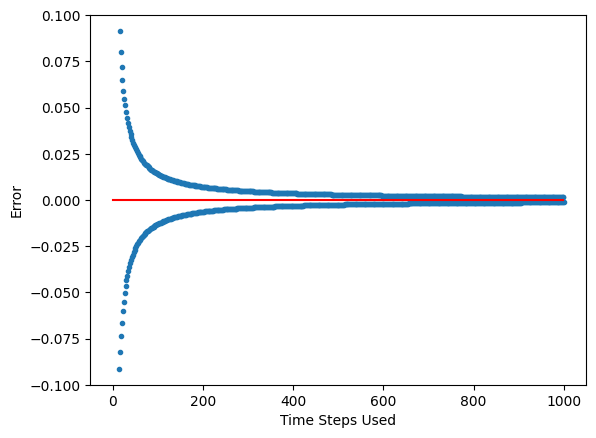

In [ ]:
plt.scatter(range(1,1001),errors_am,marker='.')
plt.plot(np.zeros(1000),color='red')
plt.xlabel("Time Steps Used")
plt.ylabel("Error");
plt.ylim([-0.1,0.1]);

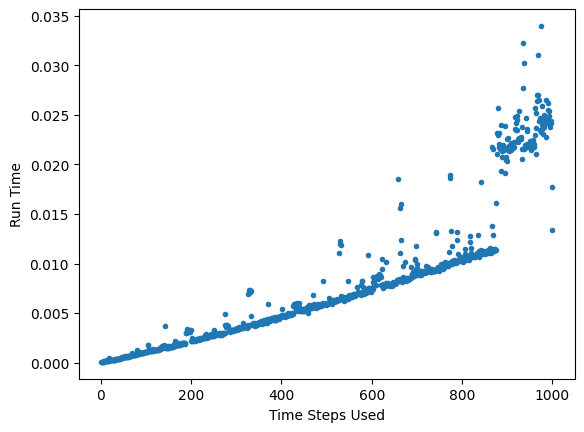

In [ ]:
plt.scatter(range(1,1001),times_am,marker='.')
plt.xlabel("Time Steps Used")
plt.ylabel("Run Time");